In [2]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,Dropout
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
x_train = x_train.reshape(50000, 32, 32, 3).astype("float32") / 255
x_test = x_test.reshape(10000, 32, 32, 3).astype("float32") / 255
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)

(50000, 32, 32, 3)


In [24]:
inputs = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x=Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x=Dropout(0.25)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs, name="test_for_shap")
model.compile(loss='sparse_categorical_crossentropy',
      optimizer='nadam', metrics='sparse_categorical_accuracy')
model.fit(x_train, y_train, validation_data=(x_test, y_test),batch_size=64, epochs = 10)

Epoch 1/10
782/782 [==============================] - 23s 27ms/step - loss: 1.5819 - sparse_categorical_accuracy: 0.4204 - val_loss: 1.2601 - val_sparse_categorical_accuracy: 0.5559
Epoch 2/10
782/782 [==============================] - 22s 29ms/step - loss: 1.2668 - sparse_categorical_accuracy: 0.5488 - val_loss: 1.1577 - val_sparse_categorical_accuracy: 0.5828
Epoch 3/10
782/782 [==============================] - 23s 29ms/step - loss: 1.1400 - sparse_categorical_accuracy: 0.5970 - val_loss: 1.1019 - val_sparse_categorical_accuracy: 0.6074
Epoch 4/10
782/782 [==============================] - 23s 30ms/step - loss: 1.0508 - sparse_categorical_accuracy: 0.6280 - val_loss: 1.1171 - val_sparse_categorical_accuracy: 0.6139
Epoch 5/10
782/782 [==============================] - 27s 35ms/step - loss: 0.9808 - sparse_categorical_accuracy: 0.6541 - val_loss: 1.0270 - val_sparse_categorical_accuracy: 0.6387
Epoch 6/10
782/782 [==============================] - 32s 41ms/step - loss: 0.9183 - spars

In [25]:
# class label list
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

x_test_dict = dict()
for i, l in enumerate(y_test):
  if len(x_test_dict)==10:
    break
  if l not in x_test_dict.keys():
    x_test_dict[l] = x_test[i]
# order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)
# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 64ms/step


In [26]:
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  
  for k,v in images.items():
    ax = axes[k]
    ax.imshow(v)
    ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()

In [27]:
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(x_test_each_class)
print(type(shap_values))
print(np.array(shap_values).shape)#(class별, obs별, shap values)

<class 'list'>
(10, 10, 32, 32, 3)


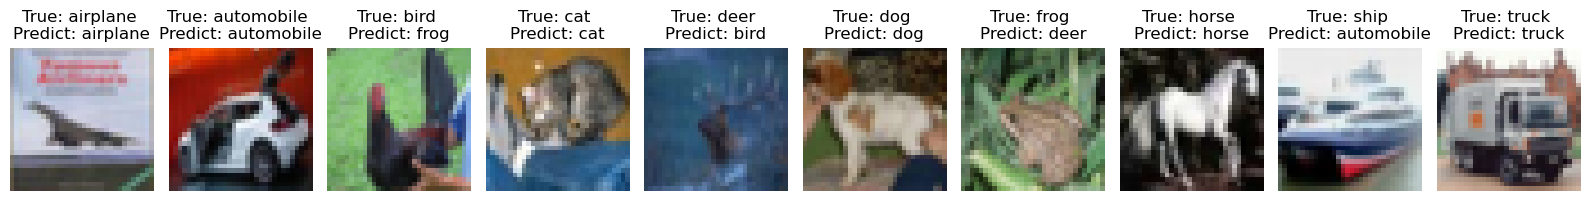

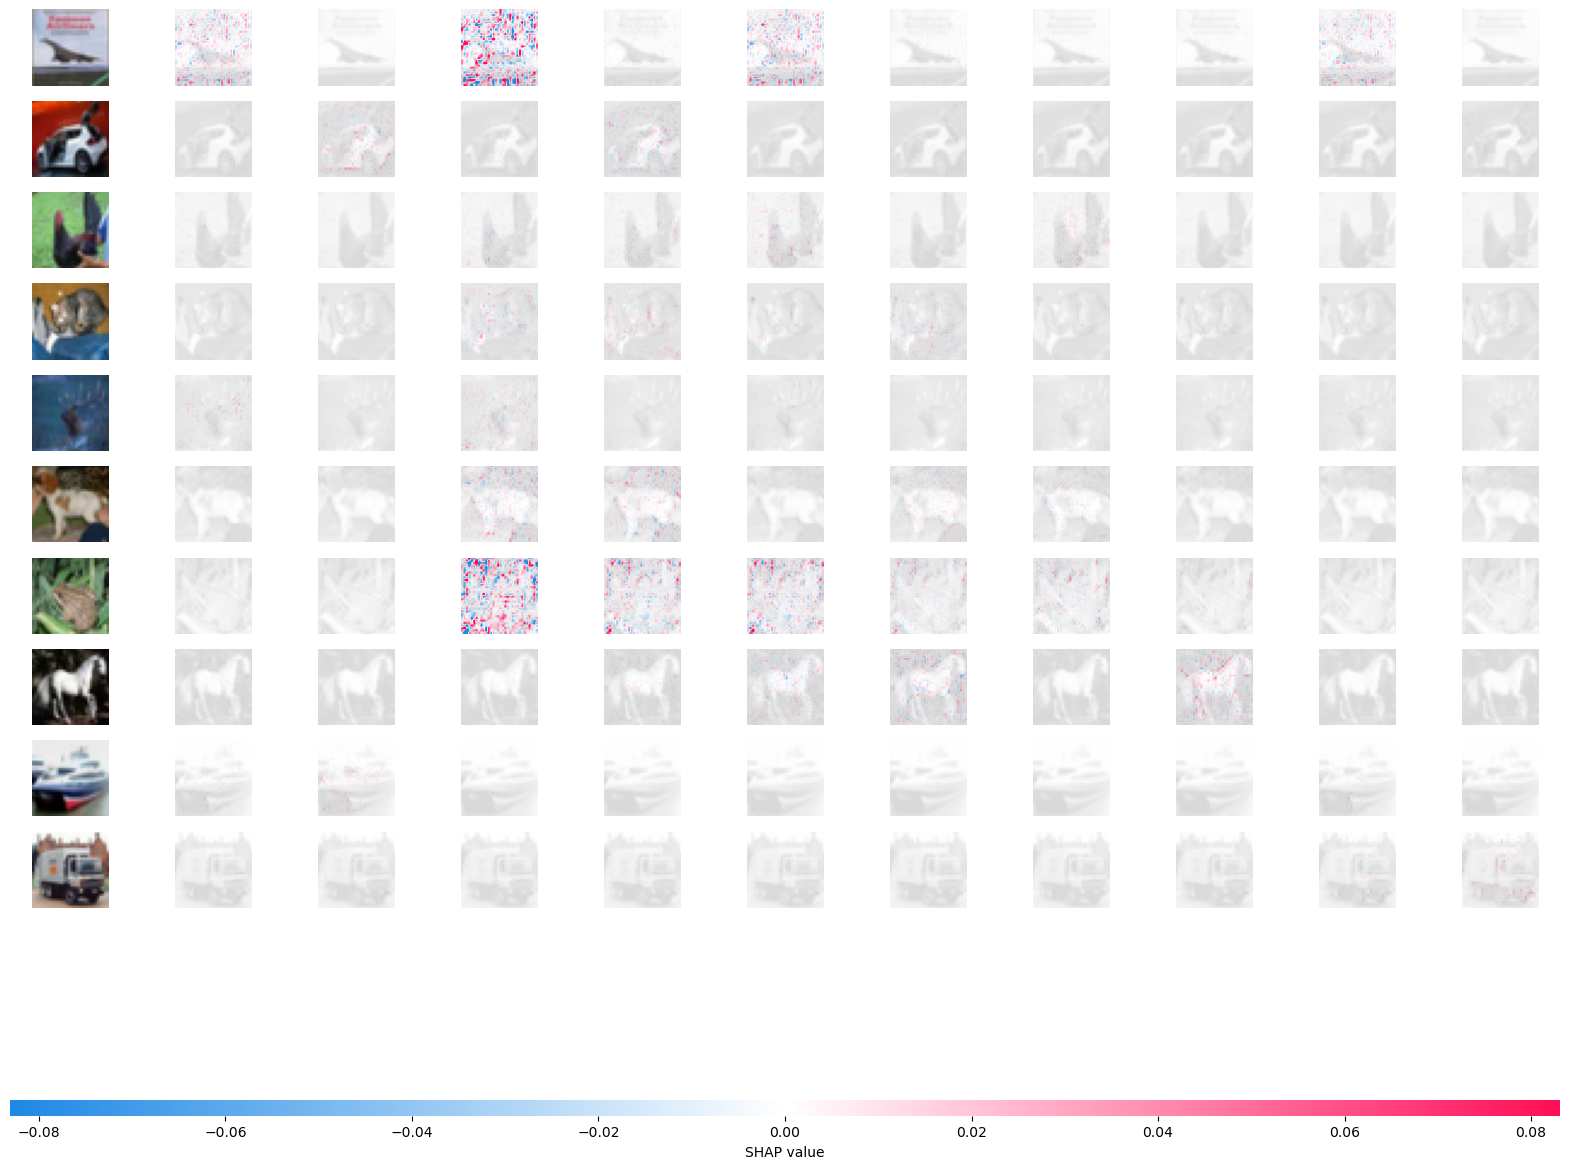

In [28]:
# plot SHAP values
plot_actual_predicted(x_test_dict, predicted_class)
print()
shap.image_plot(shap_values, x_test_each_class)

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

print('x_train shape:', x_train.shape)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(64, 3, strides=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=128,epochs=20, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
Epoch 1/20
469/469 [==============================] - 16s 30ms/step - loss: 0.3067 - accuracy: 0.9038 - val_loss: 0.0615 - val_accuracy: 0.9803
Epoch 2/20
469/469 [==============================] - 15s 33ms/step - loss: 0.1034 - accuracy: 0.9686 - val_loss: 0.0419 - val_accuracy: 0.9865
Epoch 3/20
469/469 [==============================] - 16s 34ms/step - loss: 0.0794 - accuracy: 0.9759 - val_loss: 0.0348 - val_accuracy: 0.9889
Epoch 4/20
469/469 [==============================] - 16s 35ms/step - loss: 0.0665 - accuracy: 0.9793 - val_loss: 0.0317 - val_accuracy: 0.9898
Epoch 5/20
469/469 [==============================] - 17s 35ms/step - loss: 0.0590 - accuracy: 0.9818 - val_loss: 0.0337 - val_accuracy: 0.9894
Epoch 6/20
469/469 [==============================] - 17s 36ms/step - loss: 0.0532 - accuracy: 0.9837 - val_loss: 0.0279 - val_accuracy: 0.9907
Epoch 7/20
469/469 [==============================] - 17s 36ms/step - loss: 0.0477 - accuracy: 0.9854 

In [3]:
import shap
import numpy as np

results=np.argmax(model.predict(x_test[1:5]),axis=-1)
print(results)

background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(x_test[1:5])
print(e.expected_value)
print(np.array(shap_values).shape)

1/1 [==============================] - 0s 156ms/step
[2 1 0 4]


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
tf.Tensor(
[0.08801326 0.11080177 0.09745354 0.09867933 0.09679049 0.09706668
 0.11697716 0.10978016 0.09290546 0.0915321 ], shape=(10,), dtype=float32)
(10, 4, 28, 28, 1)


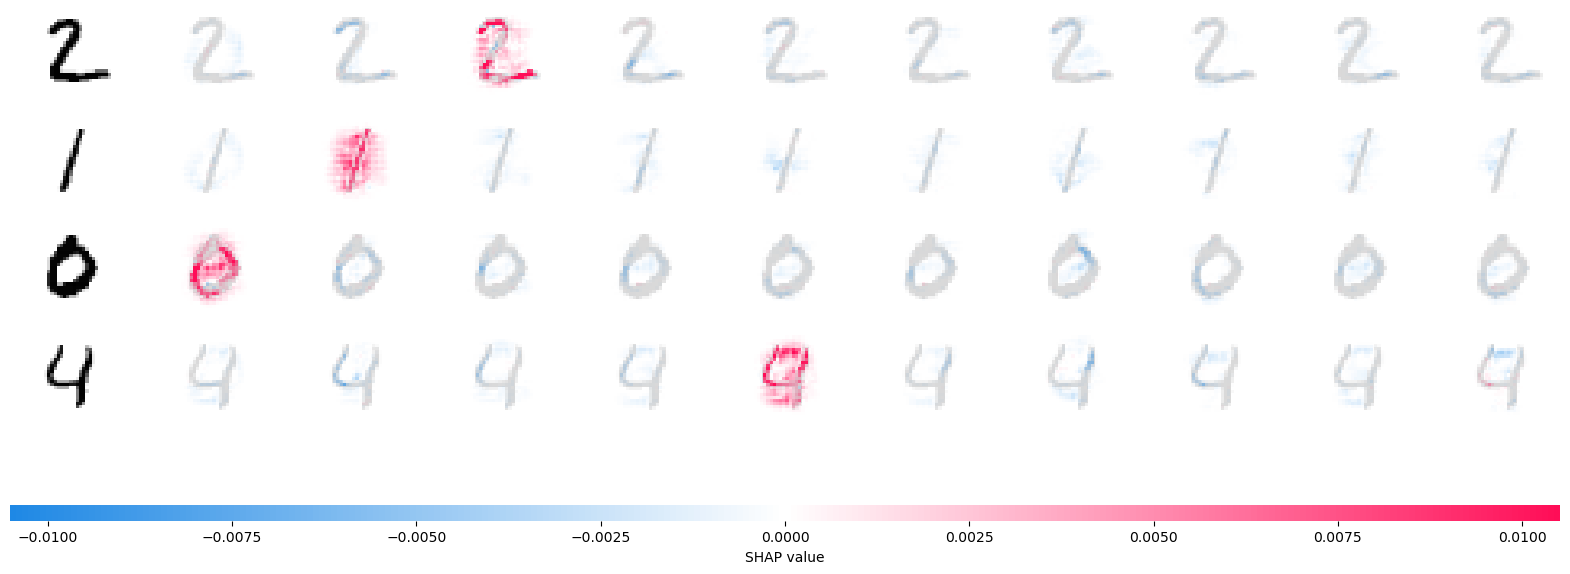

In [13]:
shap.image_plot(shap_values,-x_test[1:5])